# Heart sound classification Keras



In [1]:
import glob
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from keras.utils.np_utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
from numpy import array
from numpy import argmax 
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU, PReLU
from sklearn.model_selection import RandomizedSearchCV

C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Extracting features from audio files

The parse audio funtion takes all the files divided into subfolders with their class label names and extract features does extract meaningful features from each audio file.

In [2]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    features, labels = np.empty((0,193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            #Stack arrays in sequence horizontally (column wise).
            #a = np.array((1,2,3)) b = np.array((2,3,4))
            #np.hstack((a,b))  array([1, 2, 3, 2, 3, 4])
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            #Stack arrays in sequence vertically (row wise). So each audio files features are saved in new rows
            features = np.vstack([features,ext_features]) 
            print(fn.split('/')[4].split("\\")[1])
            labels = np.append(labels, fn.split('/')[4].split("\\")[1])
            #labels = np.append(labels, fn.split('/')[6].split('-')[2][0])
    return np.array(features), np.array(labels)


In [ ]:
parent_dir = 'C:/Users/apt/Desktop/physionet'
sub_dirs = ['testmur','testnorm']
features, labels = parse_audio_files(parent_dir,sub_dirs)


Saved the features in NP array so as reuse and avoid repeated time consuming feature extraction

In [4]:

np.save("TestRecordedNormalJhonMurmurFeatures" + '.npy', features)
np.save("TestRecordedNormalJhonMurmurLabels" + '.npy', labels)


In [10]:

features = np.load("Trainingpsypeter2Features"+ '.npy')
labels = np.load("Trainingpsypeter2Labels" + '.npy')

Testfeatures = np.load("TestRecordedNormalJhonMurmurFeatures"+ '.npy')
testLabels = np.load("TestRecordedNormalJhonMurmurLabels" + '.npy')

print("========================The extracted features================")

print(features)
print("==============================================================")
print("=====The labels of classification in categorical variable======")
print(labels)
print("===================Labels converted to binary ==============================")
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
print(integer_encoded)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
labels = onehot_encoder.fit_transform(integer_encoded)

print("=====Then to one hot encoding as ML algorithms cannot work with categorical data directly=====")

print(labels)
# invert first example
#inverted = label_encoder.inverse_transform([argmax(onehot_encoded[::-1])])
#print(inverted)
#labels = tf.keras.utils.to_categorical(labels, 3)
#train_test_split = np.random.rand(len(features)) < 0.70
train_x = features[train_test_split]
train_y = labels[train_test_split]
print(train_test_split)
test_x = features[~train_test_split]
test_y = labels[~train_test_split]
print("===================Input shape ==============================")
#features = np.asarray(features).reshape(len(features),193,1)
#labels = np.asarray(labels).reshape(len(labels),2,1)
print(features.shape)
print(labels.shape)



========================The extracted features================
[[-3.86631022e+02  1.78301213e+02  6.85775411e+01 ...  1.33809307e-02
   3.61587288e-03  1.16107564e-02]
 [-3.92341076e+02  1.79758613e+02  6.16161795e+01 ...  2.73219725e-02
   1.05619922e-03  1.78745035e-02]
 [-4.01152468e+02  1.69678650e+02  6.85314371e+01 ...  1.21206933e-02
   4.79127069e-03  1.23095707e-02]
 ...
 [-4.53560591e+02  1.50814845e+02  1.05998614e+02 ...  3.75065411e-02
   1.16891035e-02  1.23915670e-02]
 [-4.46932479e+02  1.71429773e+02  1.17186192e+02 ...  1.11238218e-02
   4.40638816e-03  4.38996250e-03]
 [-4.72077197e+02  1.46631426e+02  1.06092229e+02 ...  2.86870771e-02
   7.12759197e-03  1.56826852e-02]]
=====The labels of classification in categorical variable======
['normal' 'normal' 'normal' ... 'abnormal' 'abnormal' 'abnormal']
===================Labels converted to binary ==============================
[1 1 1 ... 0 0 0]
=====Then to one hot encoding as ML algorithms cannot work with categorical 

# Tensorflow approch

Initially have built Artificial Neural network thorugh Tensor flow

In [11]:
training_epochs = 2000
n_dim = features.shape[1]
print(features.shape)
print(features.shape[1])
n_classes = 2
n_hidden_units_one = 300 
n_hidden_units_two = 400
n_hidden_units_three = 350
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

(1825, 193)
193


In [7]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])


W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.relu(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.tanh(tf.matmul(h_1,W_2) + b_2)


W_3 = tf.Variable(tf.random_normal([n_hidden_units_two, n_hidden_units_three], mean = 0, stddev=sd))
b_3 = tf.Variable(tf.random_normal([n_hidden_units_three], mean = 0, stddev=sd))
h_3 = tf.nn.sigmoid(tf.matmul(h_2,W_3) + b_3)


W = tf.Variable(tf.random_normal([n_hidden_units_three,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_3,W) + b)

init = tf.global_variables_initializer()

In [8]:
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
    save_path = saver.save(sess, "C:/Users/apt/Desktop/model.ckpt")

In [ ]:
with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "C:/Users/apt/Desktop/model.ckpt")

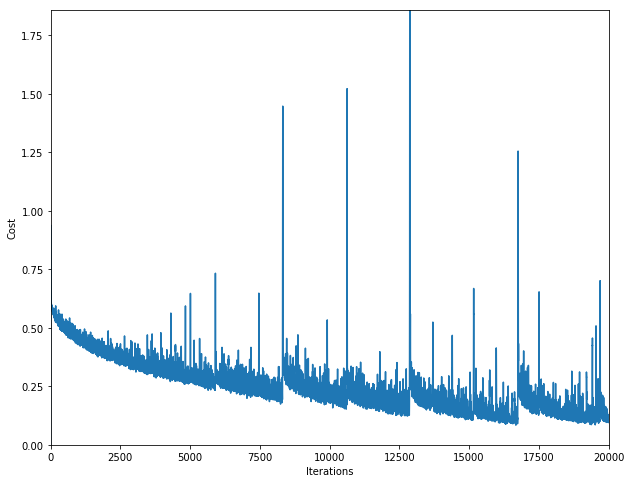

F-Score: 0.777
F-Score: 0.777
F-Score: 0.777
F-Score: None


In [28]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
print("F-Score:", round(p,3))
print("F-Score:", round(r,3))
print("F-Score:", s)

# Keras over tensorflow

In [17]:
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def assure_path_exists(path):
    mydir = os.path.join(os.getcwd(), path)
    if not os.path.exists(mydir):
        os.makedirs(mydir)

# neural network dimensions
n_dim = train_x.shape[1]
n_classes = train_y.shape[1]
n_hidden_units_1 = n_dim
n_hidden_units_2 = 400 # approx n_dim * 2
n_hidden_units_3 = 600
n_hidden_units_4 = 400 #
n_hidden_units_5 = 200 # half of layer 2

checkpoint_dir = "model"
assure_path_exists(checkpoint_dir)

print ("Features:", n_dim, "Classes:", n_classes)

Features: 193 Classes: 2


In [31]:
tf.set_random_seed(0)
np.random.seed(0)

def create_model(activation_function='relu', init_type='normal', optimiser='RMSprop', dropout_rate=0.5):
    model = Sequential()
    # layer 1
    model.add(Dense(n_hidden_units_1, input_dim=n_dim, init=init_type, activation='relu'))
    # layer 2
    model.add(Dense(n_hidden_units_2, init=init_type, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    # layer 3
    model.add(Dense(n_hidden_units_3, init=init_type, activation='tanh'))
    model.add(Dropout(dropout_rate))
     # layer 4
    model.add(Dense(n_hidden_units_4, init=init_type, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    #model.add(Dense(n_hidden_units_4, init=init_type, activation='relu'))
    #model.add(Dropout(dropout_rate))
    
 
    
    # output layer
    model.add(Dense(n_classes, init=init_type, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model

# a stopping function to stop training before we excessively overfit to the training set
earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

model = create_model()

history = model.fit(train_x, train_y,  nb_epoch=100, batch_size=10, validation_data=(test_x, test_y))

C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(193, input_dim=193, activation="relu", kernel_initializer="normal")`
  import sys
C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="sigmoid", kernel_initializer="normal")`
  if __name__ == '__main__':
C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="tanh", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `

Train on 1269 samples, validate on 556 samples
Epoch 1/100
1269/1269 [==============================] - 3s 2ms/step - loss: 0.8836 - acc: 0.5248 - val_loss: 0.7690 - val_acc: 0.5701
Epoch 2/100
1269/1269 [==============================] - 2s 2ms/step - loss: 0.7696 - acc: 0.5406 - val_loss: 0.6882 - val_acc: 0.5701
Epoch 3/100
1269/1269 [==============================] - 2s 2ms/step - loss: 0.7442 - acc: 0.5382 - val_loss: 0.6756 - val_acc: 0.5701
Epoch 4/100
1269/1269 [==============================] - 2s 2ms/step - loss: 0.7375 - acc: 0.5288 - val_loss: 0.7327 - val_acc: 0.4299
Epoch 5/100
1269/1269 [==============================] - 2s 2ms/step - loss: 0.7097 - acc: 0.5705 - val_loss: 0.6925 - val_acc: 0.5701
Epoch 6/100
1269/1269 [==============================] - 2s 2ms/step - loss: 0.7204 - acc: 0.5461 - val_loss: 0.6838 - val_acc: 0.5701
Epoch 7/100
1269/1269 [==============================] - 2s 2ms/step - loss: 0.7108 - acc: 0.5674 - val_loss: 0.7368 - val_acc: 0.4299
Epoch 8/

Epoch 61/100
1269/1269 [==============================] - 2s 2ms/step - loss: 0.6035 - acc: 0.7297 - val_loss: 0.5407 - val_acc: 0.7662
Epoch 62/100
1269/1269 [==============================] - 2s 2ms/step - loss: 0.5932 - acc: 0.7526 - val_loss: 0.5228 - val_acc: 0.7770
Epoch 63/100
1269/1269 [==============================] - 2s 2ms/step - loss: 0.5879 - acc: 0.7392 - val_loss: 0.5304 - val_acc: 0.7446
Epoch 64/100
1269/1269 [==============================] - 2s 2ms/step - loss: 0.5838 - acc: 0.7455 - val_loss: 0.6267 - val_acc: 0.7230
Epoch 65/100
1269/1269 [==============================] - 2s 2ms/step - loss: 0.5934 - acc: 0.7352 - val_loss: 0.5150 - val_acc: 0.7752
Epoch 66/100
1269/1269 [==============================] - 2s 1ms/step - loss: 0.5912 - acc: 0.7329 - val_loss: 0.5733 - val_acc: 0.7752
Epoch 67/100
1269/1269 [==============================] - 2s 2ms/step - loss: 0.5972 - acc: 0.7510 - val_loss: 0.5725 - val_acc: 0.7266
Epoch 68/100
1269/1269 [========================

# Accuracy 

In [11]:
from sklearn import metrics 
from keras.utils import np_utils


# obtain the prediction probabilities
y_prob = model.predict_proba(test_x, verbose=0)
#y_pred = np_utils.probas_to_classes(y_prob)
#replaced above probas_to_classes as updated keras doesnt have it  
y_pred = y_prob.argmax(axis=-1)
y_true = np.argmax(test_y, 1)

#roc = metrics.roc_auc_score(test_y, y_prob)
#print ("ROC:",  round(roc,2))

# evaluate the model
#score, accuracy = model.evaluate(test_x, test_y, batch_size=32)
#print("\nAccuracy = {:.2f}".format(accuracy))

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print ("F-Score:", round(f,3))

F-Score: 0.788


# Refinement and Optimisation

The performance of a deep neural network is highly dependent on many configurable hyper-parameters, values that govern how the model actually works, and which are not changed during the course of learning. Some of these parameters will have a greater influence than others. The classic machine learning solution to this challenge is GridSearch, to successively train separate instances of a model with distinct values of key parameters, and then compare the resulting accuracy scores to identify which combination of parameters has produced the best results.

Have started searching for best parameters using this startegy

In [121]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm

activations = ['relu', 'tanh', 'linear']
batch_sizes = [10, 20, 30, 40, 50, 60]
epochs = [10, 20, 30]
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

optimisers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

model = KerasClassifier(build_fn=create_model, nb_epoch=10, batch_size=24, verbose=0)
model.fit(train_x, train_y)
# define the grid search parameters
# just using one here for illustration, but add activation_function=activations 
# or dropout_rate=dropout_rates to grid search on other parameters
param_grid = dict(dropout_rate = dropout_rates )
#param_grid = dict(optimiser=optimisers, activation_function=activations, dropout_rate = dropout_rates, batch_size= batch_sizes )
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)

print ("Running GridSearch...")
grid_result = grid.fit(train_x, train_y)
print ("GridSearch complete")

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(193, input_dim=193, activation="relu", kernel_initializer="normal")`
  import sys
C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", kernel_initializer="normal")`
  if __name__ == '__main__':
C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", kernel_initializer="normal")`
  from ipykernel import kernelapp as app


Running GridSearch...
GridSearch complete
Best: 0.451208 using {'dropout_rate': 0.0}
0.451208 (0.414039) with: {'dropout_rate': 0.0}
0.215459 (0.304705) with: {'dropout_rate': 0.1}
0.220290 (0.301347) with: {'dropout_rate': 0.2}
0.240580 (0.170218) with: {'dropout_rate': 0.3}
0.119807 (0.165350) with: {'dropout_rate': 0.4}
0.248309 (0.176476) with: {'dropout_rate': 0.5}
0.131401 (0.185829) with: {'dropout_rate': 0.6}
0.161353 (0.228187) with: {'dropout_rate': 0.7}
0.117874 (0.166700) with: {'dropout_rate': 0.8}
0.124638 (0.176264) with: {'dropout_rate': 0.9}


# Generating Predictions

Once we've trained a model, we can use the following process to pass an audio file into our model and generate predictions, which will be the activation value (between Normal and Abnormal) at the output layer for each of the 2 possible classes.

In [13]:
def extract_features_only(filename):
    features = np.empty((0,193))
    X, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    features = np.vstack([features,ext_features])
    return features

In [15]:
predict_x = extract_features_only('C:/Users/apt/Desktop/Data/dataset/normal/107_1305654946865_C1.wav')
predictions = model.predict(predict_x)
print(np.argmax(predictions))

1


In [18]:
sound_file_paths = ["a0001.wav","a0002.wav","a0003.wav","a0004.wav","a0005.wav",
                   "a0006.wav","a0007.wav","a0008.wav","a0009.wav","a0010.wav", "a0011.wav","a0012.wav","a0013.wav","a0014.wav","a0015.wav",
                   "a0016.wav","a0017.wav","a0018.wav","a0019.wav","a0020.wav"]
sound_names = ["abnormal","abnormal","abnormal","abnormal","abnormal","abnormal",
               "normal","abnormal","normal","abnormal","normal","normal","abnormal","abnormal","abnormal","normal",
               "abnormal","abnormal","normal","abnormal"]
parent_dir = 'C:/Users/apt/Desktop/Data/training/training-a/'

In [24]:
for s in range(len(sound_names)):

    print ("Expected label ==>", sound_names[s])
    # load audio file and extract features
    predict_file = parent_dir + sound_file_paths[s]
    predict_x = extract_features_only(predict_file)
    #print(predict_x)
    # generate prediction, passing in just a single row of features
    predictions = model.predict(predict_x)
    #for i in range(len(predictions[0])):
    #    print sound_names[i], "=", round(predictions[0,i] * 100, 1)
    
    # get the indices of the top 2 predictions, invert into descending order
    #If you’re not familiar, the np.partition does a partial sort on the vector,
    #just separating the numbers into two groups (partitions) one of size k, and the other len-k 
    #such that all the values in the first group are less than all the values in the second.
    #That’s np.partition, while np.argpartition does the same thing but gives you the indices
    #into the vector rather than the values.
    ind = np.argpartition(predictions[0], -2)
    
    inverted = label_encoder.inverse_transform([argmax(ind)])
    print ("Predicted label ===>", inverted)
    print("-------------------------------")
    ind[np.argsort(predictions[0][ind])]
    ind = ind[::-1]
    #print(ind[0])
    #print(ind[1])
    
    
    #print ("Top guess: ", sound_names[ind[0]], " (",round(predictions[0,ind[0]],3),")")
    #print ("2nd guess: ", sound_names[ind[1]], " (",round(predictions[0,ind[1]],3),")")

Expected label ==> abnormal
Predicted label ===> ['abnormal']
-------------------------------
Expected label ==> abnormal
Predicted label ===> ['abnormal']
-------------------------------
Expected label ==> abnormal


C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\librosa\core\pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Predicted label ===> ['abnormal']
-------------------------------
Expected label ==> abnormal
Predicted label ===> ['abnormal']
-------------------------------
Expected label ==> abnormal
Predicted label ===> ['abnormal']
-------------------------------
Expected label ==> abnormal
Predicted label ===> ['abnormal']
-------------------------------
Expected label ==> normal
Predicted label ===> ['abnormal']
-------------------------------
Expected label ==> abnormal
Predicted label ===> ['abnormal']
-------------------------------
Expected label ==> normal
Predicted label ===> ['normal']
-------------------------------
Expected label ==> abnormal
Predicted label ===> ['abnormal']
-------------------------------
Expected label ==> normal
Predicted label ===> ['abnormal']
-------------------------------
Expected label ==> normal
Predicted label ===> ['normal']
-------------------------------
Expected label ==> abnormal
Predicted label ===> ['abnormal']
-------------------------------
Expect